# QRC with Learned Margin M and Two-Angle Reservoir  

In this notebook, we study an AR(2) recurrence

$y_{t+1} = \alpha y_t + \beta y_{t-1}$


In [14]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.append(str(ROOT / "src"))

from normalization import *
from qrc_model import *
from ar2 import *
from training import *
from plotting import *


## Learning an optimal normalization margin $M$

This notebook studies how the **normalization range** impacts a two-angle quantum reservoir computer (QRC)
in the **autoregressive (closed-loop)** prediction regime.

We compare three normalization strategies:

- **Train-range normalization (causal)**: Min–Max bounds estimated from the training window only.
- **Enlarged normalization**: the train-range is expanded symmetrically by a **margin factor** $M$, providing
  headroom for test amplitudes outside the training range.

For each strategy, we:
1. normalize the full series,
2. select $(\phi,\theta)$ via grid search using training loss (teacher forcing),
3. evaluate the resulting model in **closed-loop** on the test interval,
4. report the test MSE in raw space.

Finally, we scan multiple $M$ values and define $M^*$ as the margin minimizing the **test** error.


In [ ]:
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "-",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

alpha, beta = 1.05, -0.95
A, B = 0.2, 0.1

T_TRAIN = 10
T_TOTAL = 80
LAMBDA  = 1e-2

phis   = np.linspace(0, 2*np.pi, 40)
thetas = np.linspace(0, 2*np.pi, 40)

t_all = np.arange(0, T_TOTAL + 1)
y_all = generate_linear_series(alpha, beta, A, B, T_TOTAL)

print(f"AR(2): y(t+1) = {alpha} y(t) + {beta} y(t-1)")
print(f"Training up to t={T_TRAIN}, total horizon={T_TOTAL}")


AR(2): y(t+1) = 1.05 y(t) + -0.95 y(t-1)
Training up to t=10, total horizon=80


### Comparing normalization strategies and learning $M^*$

We first run the model with train-range normalization (causal).
Then, we scan enlarged normalizations for multiple margin values $M$, and select $M^*$ as the margin
minimizing the **test** MSE.



Best margin (test MSE): M* = 4.50
Minimal test MSE = 3.307e-04


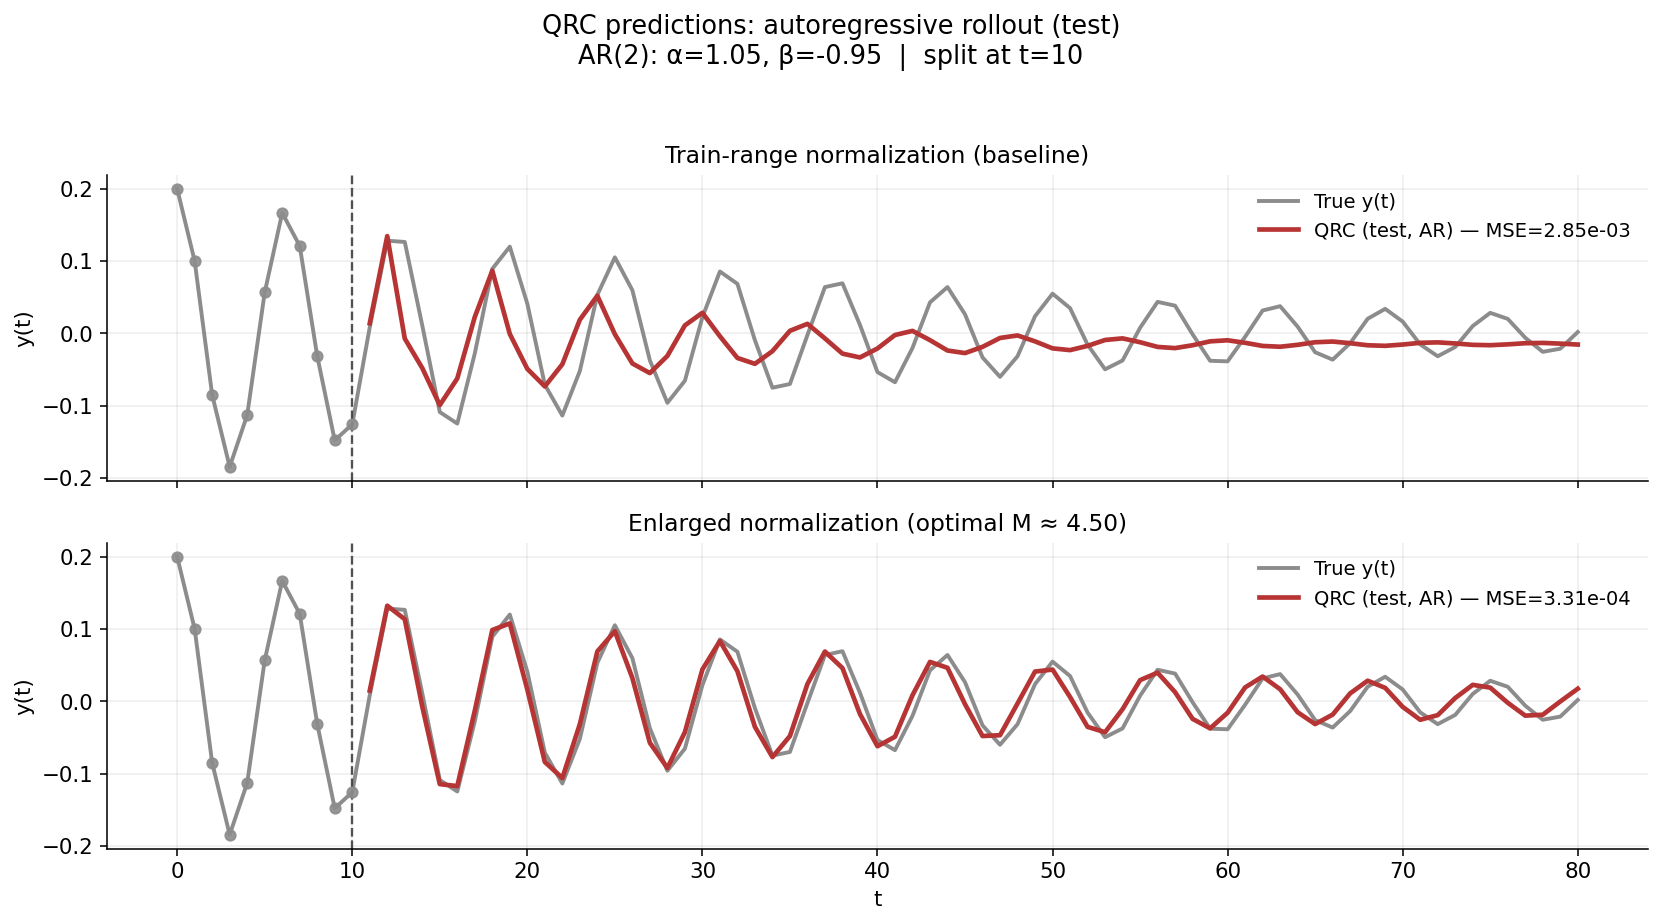

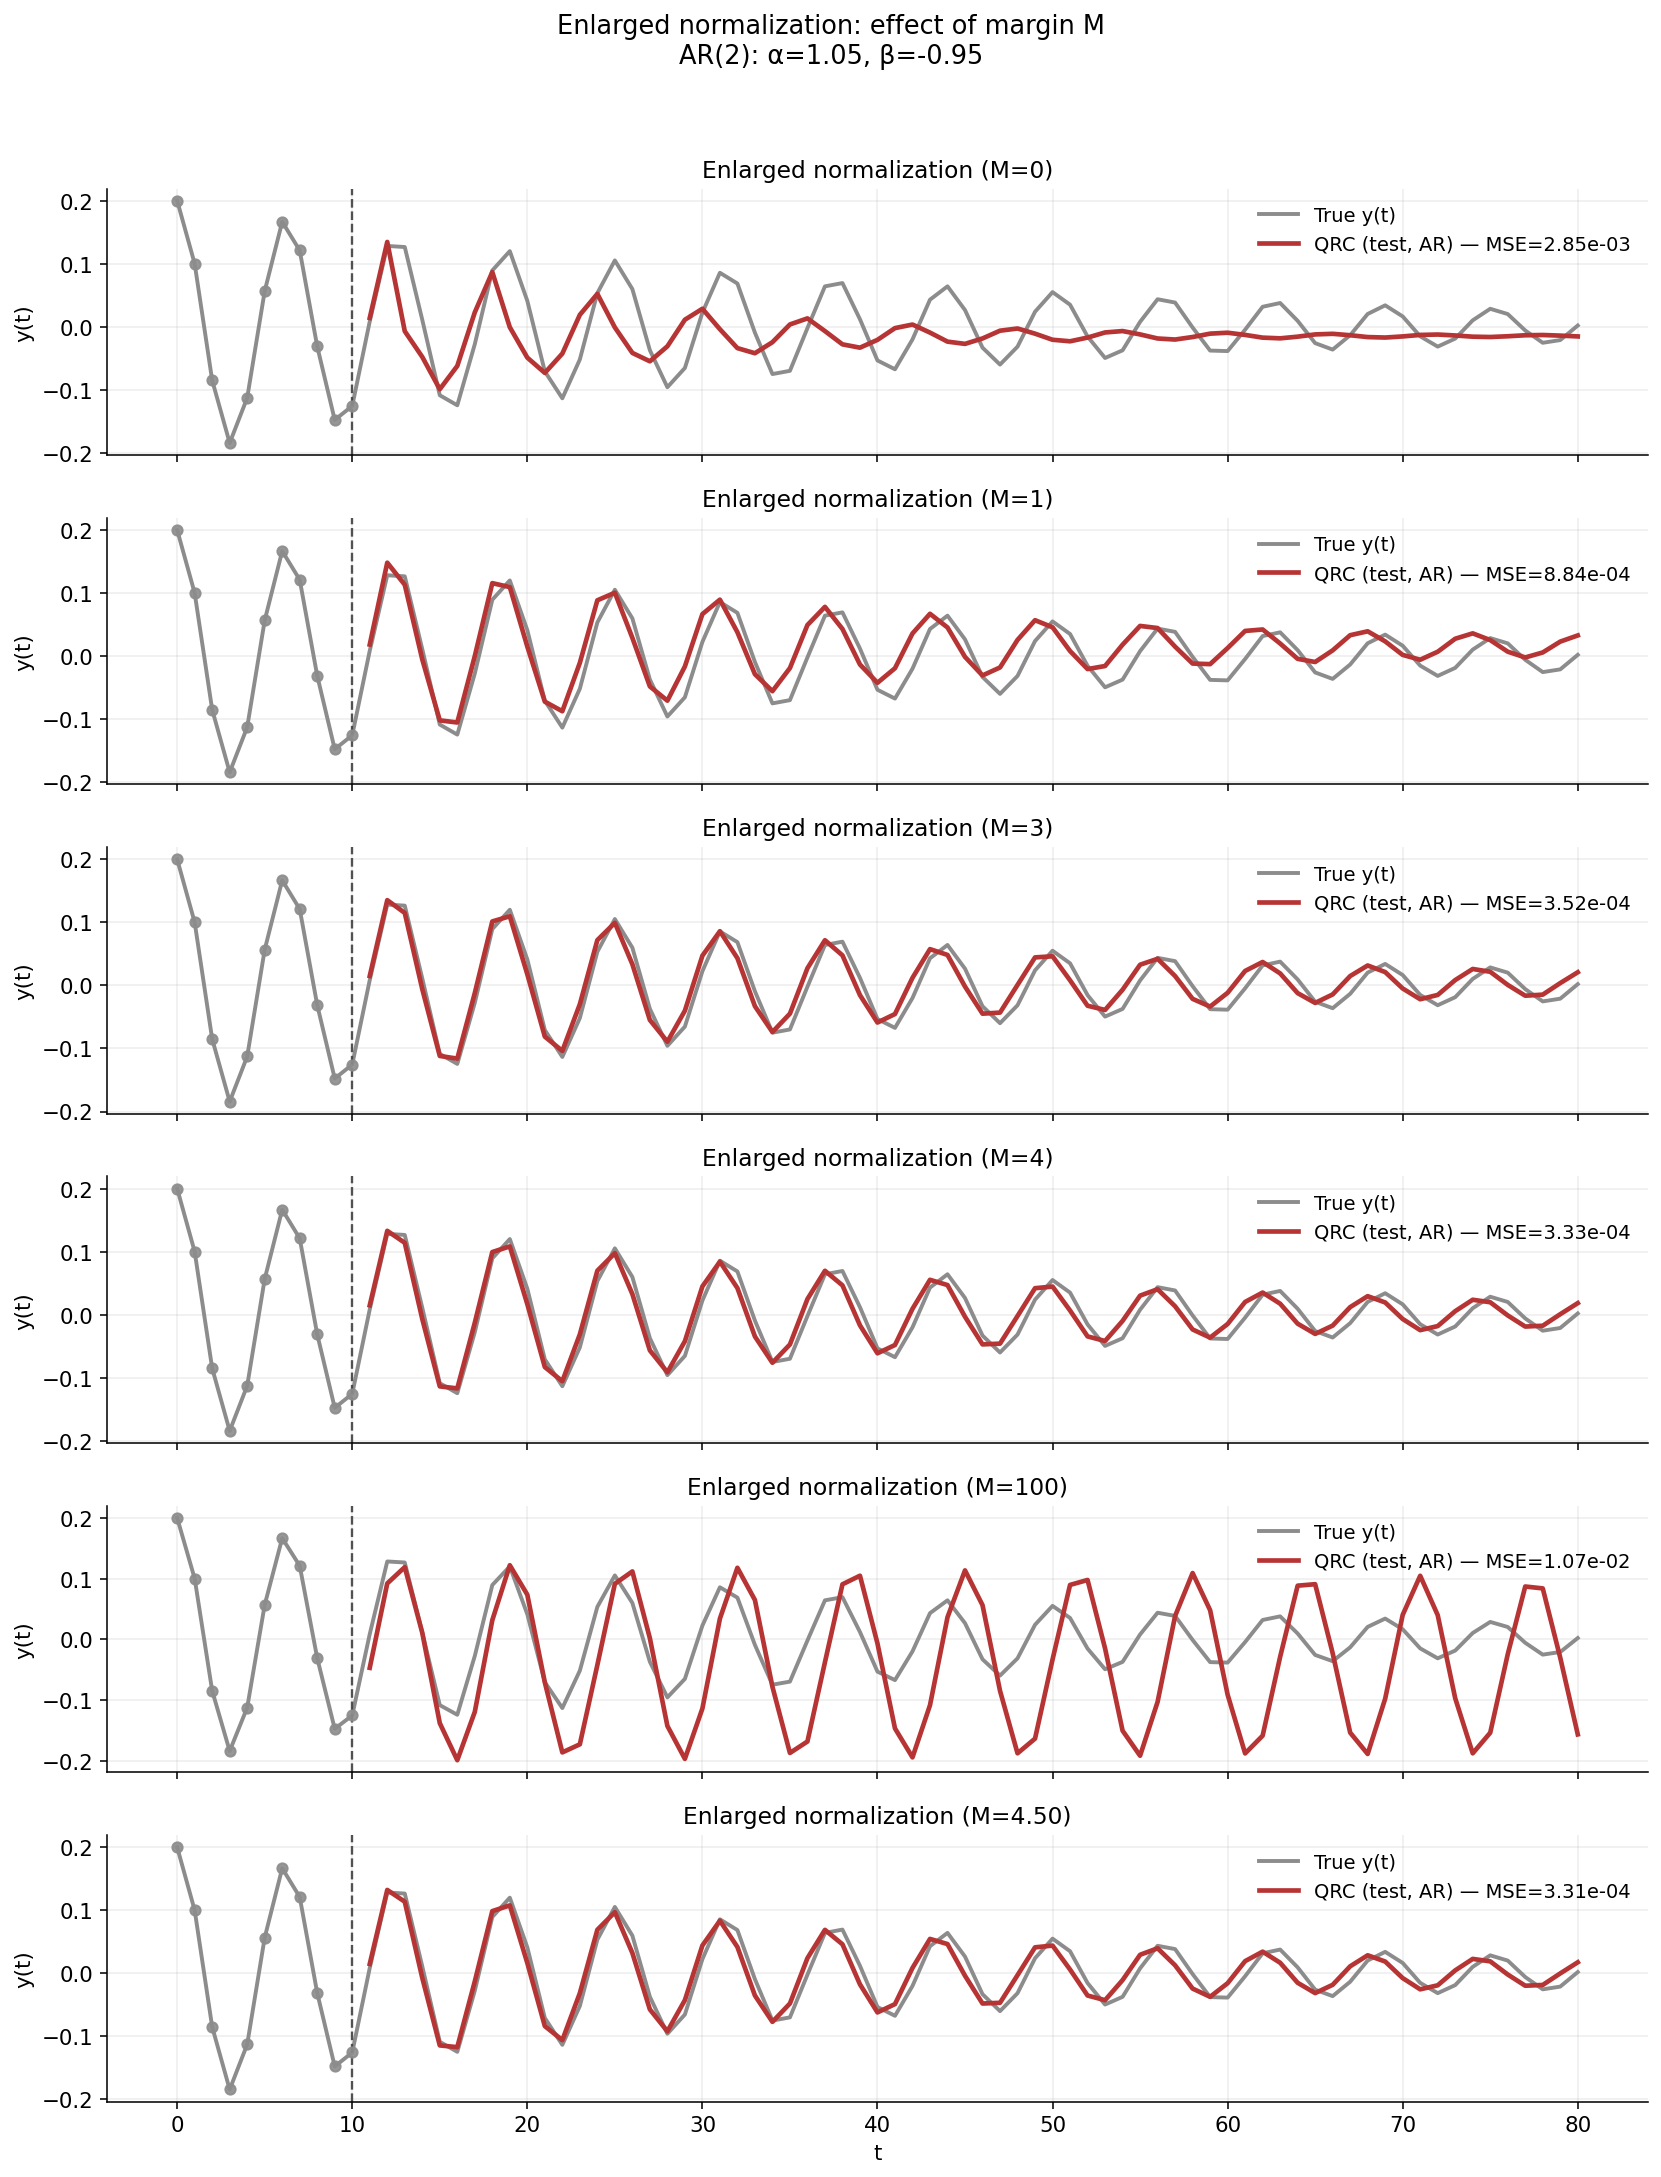

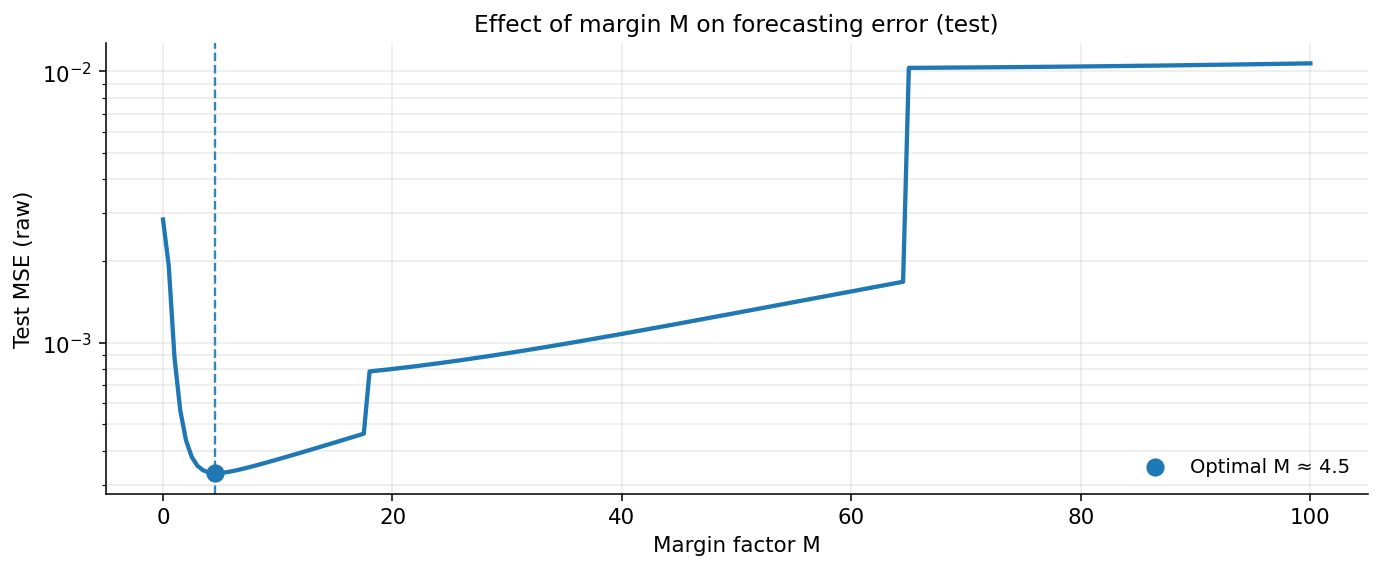

In [ ]:
res_train = run_one_setting_two_angles(
    method="train",
    y_all=y_all,
    T_TRAIN=T_TRAIN,
    T_TOTAL=T_TOTAL,
    phis=phis,
    thetas=thetas,
    lam=LAMBDA,
    margin_factor=0.0,
    clip=True,
)

M_VALUES = np.arange(0.0, 100.0 + 0.5, 0.5)
scan = scan_margin_M_test(
    M_values=M_VALUES,
    y_all=y_all,
    T_TRAIN=T_TRAIN,
    T_TOTAL=T_TOTAL,
    phis=phis,
    thetas=thetas,
    lam=LAMBDA,
    clip=False,
)

M_best = scan["M_best"]
best_run = scan["best_run"]

print(f"\nBest margin (test MSE): M* = {M_best:.2f}")
print(f"Minimal test MSE = {best_run['mse_test']:.3e}")

plot_two_normalizations(
    t_all=t_all,
    y_all=y_all,
    T_TRAIN=T_TRAIN,
    res_train=res_train,
    res_bestM=best_run,
    alpha=alpha,
    beta=beta,
)

M_SHOW = [0, 1, 3, 4, 100, M_best]
res_enl_show = [
    run_one_setting_two_angles(
        method="enlarged",
        y_all=y_all,
        T_TRAIN=T_TRAIN,
        T_TOTAL=T_TOTAL,
        phis=phis,
        thetas=thetas,
        lam=LAMBDA,
        margin_factor=float(M),
        clip=False,
    )
    for M in M_SHOW
]
plot_enlarged_multiple_M(
    t_all=t_all,
    y_all=y_all,
    T_TRAIN=T_TRAIN,
    results_list=res_enl_show,
    alpha=alpha,
    beta=beta,
)

plot_metric_vs_M(
    M_values=scan["M_values"],
    values=scan["test_mse"],
    ylabel="Test MSE (raw)",
    title="Effect of margin M on forecasting error (test)",
    logy=True,
    marker_x=M_best,
    marker_y=best_run["mse_test"],
    marker_label=f"Optimal M ≈ {M_best:.1f}",
)
